# Calibrating the number of iterations ($i_{\max}$) to run GRASP

In [15]:
import pandas as pd
from grasp_iters import read_results, DIRPATH

save = True
names = [
    "rat783_522_261_0_p20_a2", # 0
    "rat783_522_261_0_p20_a3",
    "rl1323_882_441_0_p20_a2", # 2
    "rl1323_882_441_0_p20_a3",
    "anpcp_882_441_0_p20_a2",  # 4
    "anpcp_882_441_0_p20_a3",

    "rl1323_882_441_0_p44_a2", # 6
    "rl1323_882_441_0_p44_a3",
    "anpcp_882_441_0_p44_a2",  # 8
    "anpcp_882_441_0_p44_a3",
]
name = names[8]

iters = read_results(name)
iters

,iter,beta,RGD_OF,AFVS_OF,time,is_new_best
0,0,0.405829,3130,2275,4.448111,True
1,1,0.041088,3154,2297,8.481972,False
2,2,0.442776,3231,2276,13.431608,False
3,3,0.902533,3948,2224,22.323387,True
4,4,0.334442,2930,2414,23.981288,False
...,...,...,...,...,...,...
4995,4995,0.516789,2819,2247,19326.091440,False
4996,4996,0.014482,2729,2306,19330.966597,False
4997,4997,0.917886,4239,2305,19334.259631,False
4998,4998,0.248252,3228,2443,19336.226183,False


In [23]:
iters["time"].diff().mean()

3.868167949449895

In [17]:
def get_improvs(iters_df: pd.DataFrame):
    improvs = iters_df[iters_df["is_new_best"] == True].drop("is_new_best", axis=1)

    # multiplication is negative because the problem is a minimization problem,
    # a decrease in the objective function (a negative percent change) means a better solution
    percents = improvs["AFVS_OF"].pct_change().mul(-100)
    improvs.insert(loc=4, column="imp", value=percents)

    # iterations without improvement (iwi)
    iter_diffs = improvs["iter"].diff().fillna(0).astype(int)
    improvs.insert(loc=6, column="iwi", value=iter_diffs)

    return improvs

In [18]:
improvs = get_improvs(iters)
improvs

,iter,beta,RGD_OF,AFVS_OF,imp,time,iwi
0,0,0.405829,3130,2275,NaN,4.448111,0
3,3,0.902533,3948,2224,2.241758,22.323387,3
5,5,0.753950,4278,2209,0.674460,33.345567,2
7,7,0.424298,3038,2206,0.135808,41.993702,2
10,10,0.300659,3154,2185,0.951949,57.053919,3
110,110,0.304206,3154,2166,0.869565,452.614909,100
1541,1541,0.126376,3140,2165,0.046168,6040.190471,1431
3710,3710,0.693006,3779,2161,0.184758,14531.352517,2169


In [19]:
from utils import format_latex_table

if save:
    format_latex_table(improvs, f"{DIRPATH}\\iters_improvs_{name}.tex");

In [20]:
import matplotlib.pyplot as plt

def plot_improvs(
    iters_df: pd.DataFrame,
    lastimprov: int,
    annotation_xdiff: int,
    annotation_ydiff: int,
    color: str = "blue",
    filename: str = ""
):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
    
    ax.plot(
        iters_df["iter"][:lastimprov],
        iters_df["AFVS_OF"].cummin()[:lastimprov],
        color=color,
    )

    for _, row in improvs.iterrows():
        of = int(row["AFVS_OF"])
        i = int(row["iter"])
        percent = row["imp"]

        ax.annotate(
            f"x(S) = {of}",
            (i, of),
            xytext=(i + annotation_xdiff, of + annotation_ydiff),
        )

    ax.set_title(f"Improvements in $S$ during GRASP")
    ax.set_ylabel("$x(S)$")
    ax.set_xlabel("Iteration")

    if filename:
        fig.savefig(filename, bbox_inches="tight")
    else:
        plt.show()

Manually adjust parameters to plot each instance

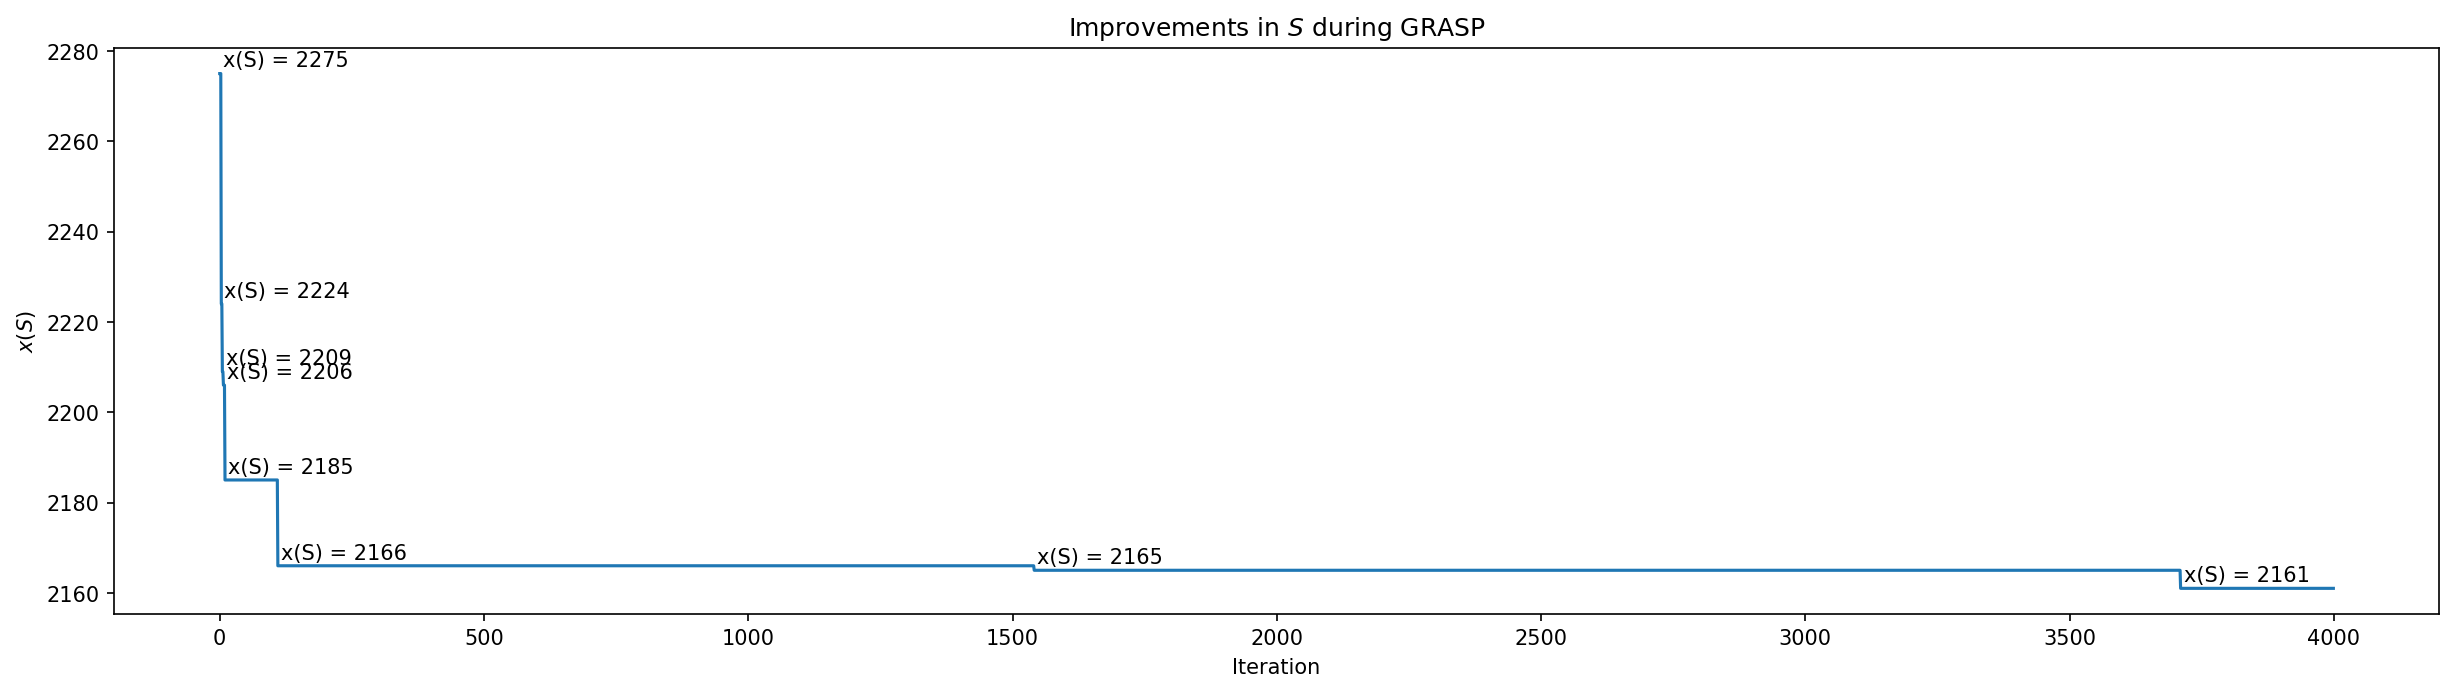

In [31]:
plot_improvs(
    iters, 4000, 6, 1.5,
    "tab:blue" if name.endswith("2") else "tab:red",
    f"{DIRPATH}\\iters_plot_{name}.png" if save else ""
)